## Курсовой проект

### Импорты

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


### Функции

Уменьшение используемой памяти

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Оценка качества модели

In [3]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [4]:
def get_feature_names(dataset, target):
    return list(filter(lambda x: x != target, dataset.columns.tolist()))

In [5]:
def get_feature_importance(columns, model):
    feature_importances = pd.DataFrame(zip(columns, model.feature_importances_), 
                                    columns=['feature_name', 'importance'])

    return feature_importances.sort_values(by='importance', ascending=False)

### Загрузка данных

In [6]:
DATASET_PATH = "./train.csv"
df_train = pd.read_csv(DATASET_PATH)
df_train = reduce_mem_usage(df_train)
#df_train = df_train.sample(frac=1, random_state=42)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [7]:
TEST_DATASET_PATH = "./test.csv"
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


### Анализ пропусков, выбросов и типов данных

In [8]:
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [9]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [10]:
df_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Распределение целевой переменной

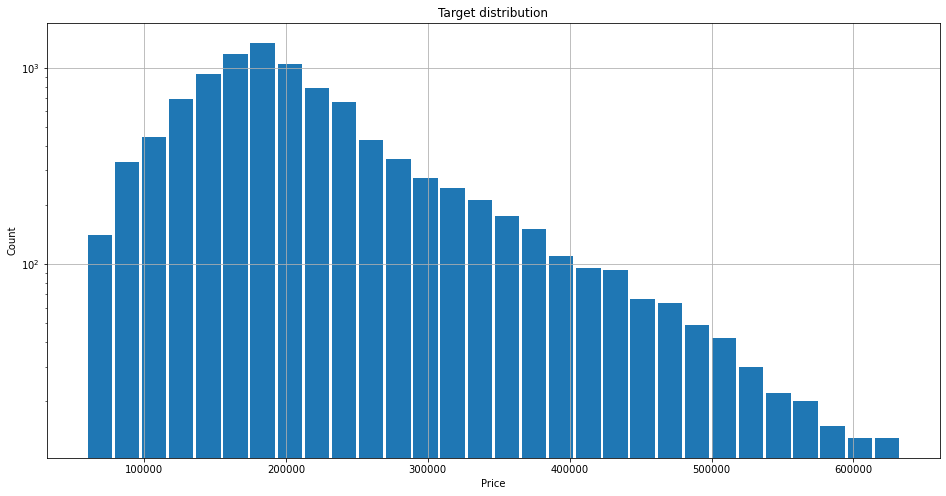

In [11]:
plt.figure(figsize = (16, 8))

df_train['Price'].hist(bins=30, log=True, rwidth=0.9)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Rooms

In [12]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [13]:
df_train[(df_train['Rooms'] > 6) | (df_train['Rooms'] < 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
2728,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625
3780,7317,27,0.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
6088,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
6401,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875
7644,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
7929,456,6,0.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
9767,12638,27,0.0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000


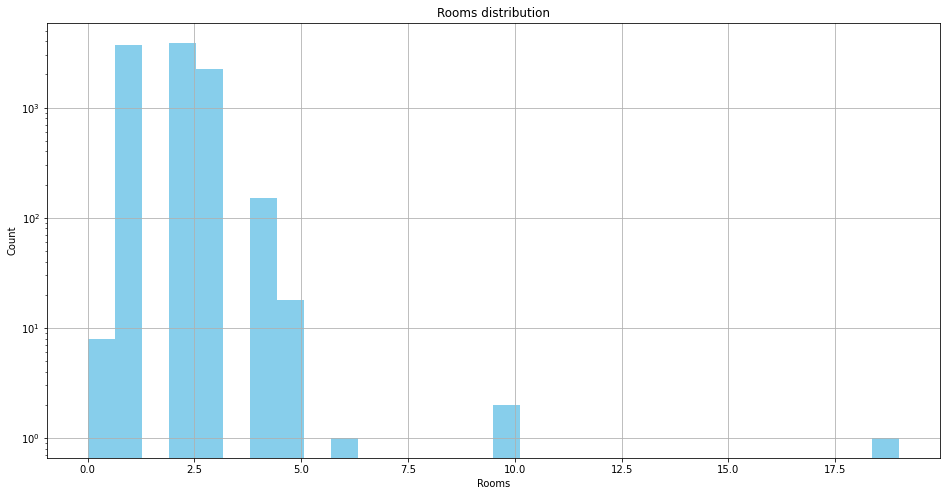

In [14]:
plt.figure(figsize = (16, 8))

df_train['Rooms'].hist(bins=30, color='skyblue', log=True)
plt.ylabel('Count')
plt.xlabel('Rooms')

plt.title('Rooms distribution')
plt.show()

Square

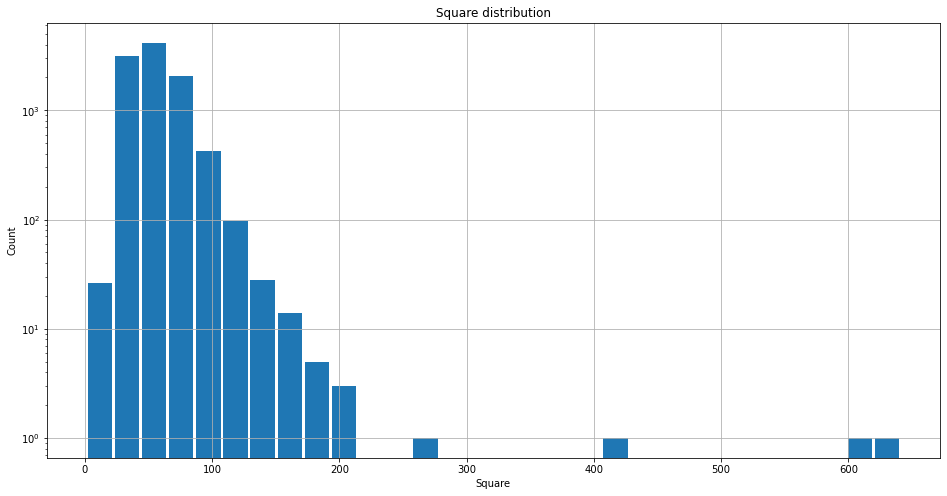

In [15]:
plt.figure(figsize = (16, 8))

df_train['Square'].hist(bins=30, log=True, rwidth=0.9)
plt.ylabel('Count')
plt.xlabel('Square')

plt.title('Square distribution')
plt.show()

In [16]:
df_train[(df_train['Square'] < 6) | (df_train['Square'] > 300)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.187500
328,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.062500
726,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.250000
1401,9487,5,1.0,5.129221,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.406250
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.781250
4800,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.500000
5009,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.265625
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
7033,1748,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.093750
7470,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.828125


LifeSquare

In [17]:
df_train['LifeSquare'].sort_values()

3113    0.370619
1829    0.641822
119     0.795539
9869    0.873147
6882    1.049867
          ...   
9975         NaN
9978         NaN
9981         NaN
9983         NaN
9991         NaN
Name: LifeSquare, Length: 10000, dtype: float32

In [18]:
df_train['LifeSquare'].min(), df_train['LifeSquare'].max()

(0.37061941623687744, 7480.59228515625)

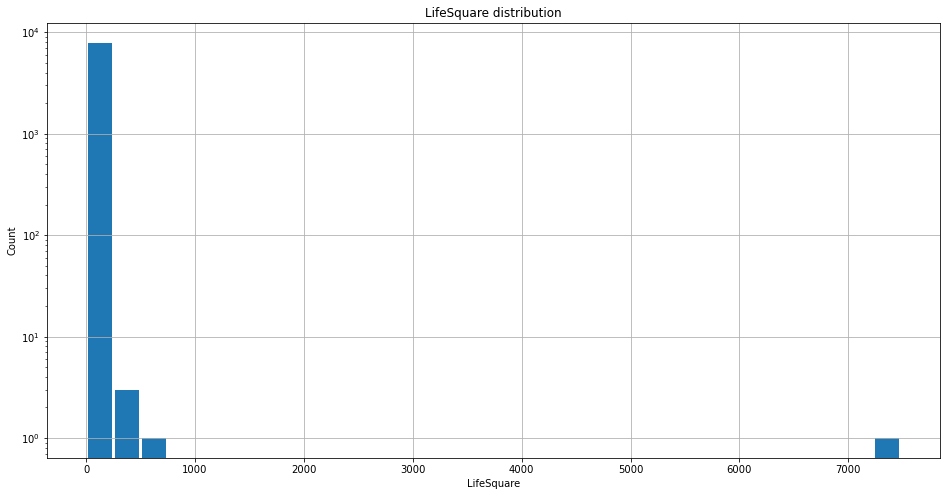

In [19]:
plt.figure(figsize = (16, 8))

df_train['LifeSquare'].hist(bins=30, log=True, rwidth=0.9)
plt.ylabel('Count')
plt.xlabel('LifeSquare')

plt.title('LifeSquare distribution')
plt.show()

KitchenSquare

In [20]:
df_train['KitchenSquare'].sort_values()

2178       0.0
5612       0.0
519        0.0
8814       0.0
3709       0.0
         ...  
7733     112.0
5002     112.0
286      123.0
6505    1970.0
9520    2014.0
Name: KitchenSquare, Length: 10000, dtype: float32

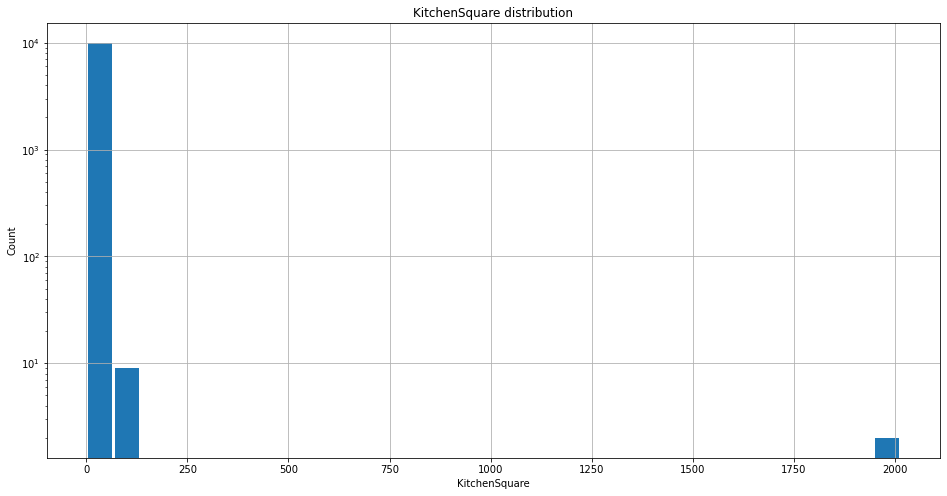

In [21]:
plt.figure(figsize = (16, 8))

df_train['KitchenSquare'].hist(bins=30, log=True, rwidth=0.9)
plt.ylabel('Count')
plt.xlabel('KitchenSquare')

plt.title('KitchenSquare distribution')
plt.show()

Floor & HouseFloor

In [22]:
df_train['Floor'].sort_values()

4982     1
9869     1
9392     1
7845     1
3195     1
        ..
1360    32
7984    32
2383    33
7599    37
4987    42
Name: Floor, Length: 10000, dtype: int8

In [23]:
df_train['HouseFloor'].sort_values()

2768      0.0
1928      0.0
5104      0.0
6870      0.0
6860      0.0
        ...  
5031     48.0
4987     48.0
746      99.0
4657     99.0
1678    117.0
Name: HouseFloor, Length: 10000, dtype: float32

In [24]:
df_train[df_train['Floor'] > df_train['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299601,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.921875
19,367,45,1.0,42.367290,40.012527,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.984375
21,8471,20,3.0,75.611061,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.250000
24,4717,27,1.0,44.203945,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.562500
25,4521,6,2.0,65.409966,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.265625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056786,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.562500
9968,9920,1,3.0,86.487549,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.937500
9970,13501,6,1.0,41.310417,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.828125
9975,4944,6,2.0,52.573132,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031250


HouseYear

In [25]:
df_train['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int32

Ecology

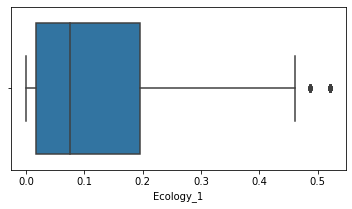

In [26]:
plt.figure(figsize=(6, 3))

sns.boxplot(x=df_train['Ecology_1'], whis=1.5)

plt.xlabel('Ecology_1')
plt.show()

In [27]:
df_train[df_train['Ecology_1'] > 0.5]['Price'].median()

156339.25

Social

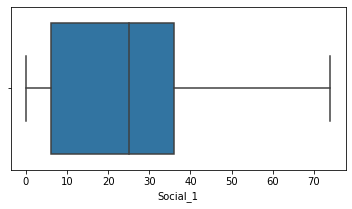

In [28]:
plt.figure(figsize=(6, 3))

sns.boxplot(x=df_train['Social_1'], whis=1.5)

plt.xlabel('Social_1')
plt.show()

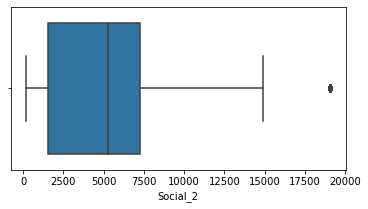

In [29]:
plt.figure(figsize=(6, 3))

sns.boxplot(x=df_train['Social_2'], whis=1.5)

plt.xlabel('Social_2')
plt.show()

In [30]:
df_train[df_train['Social_2'] > 15000]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
238,557,12,2.0,57.154362,35.821953,9.0,9,14.0,1995,0.090799,B,B,74,19083,2,NaN,5,15,B,239606.500000
300,2093,13,1.0,42.660480,20.712299,8.0,14,12.0,2004,0.090799,B,B,74,19083,2,NaN,5,15,B,179353.500000
339,12757,57,3.0,78.573654,47.297791,10.0,19,22.0,2000,0.090799,B,B,74,19083,2,NaN,5,15,B,350921.843750
360,6572,13,1.0,41.112164,21.782814,7.0,11,17.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,175032.093750
403,13434,13,5.0,183.382278,100.985504,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.812500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9817,14082,13,1.0,44.037563,20.725393,8.0,5,12.0,1996,0.090799,B,B,74,19083,2,NaN,5,15,B,188395.640625
9847,12839,13,2.0,47.421494,34.871941,6.0,9,12.0,1980,0.090799,B,B,74,19083,2,NaN,5,15,B,197873.968750
9856,4217,13,2.0,56.766533,33.111538,8.0,4,14.0,1990,0.090799,B,B,74,19083,2,NaN,5,15,B,238492.078125
9893,10736,13,3.0,80.030327,47.801598,10.0,16,17.0,1992,0.090799,B,B,74,19083,2,NaN,5,15,B,311528.093750


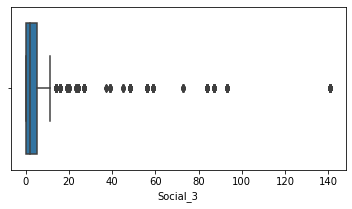

In [31]:
plt.figure(figsize=(6, 3))

sns.boxplot(x=df_train['Social_3'], whis=1.5)

plt.xlabel('Social_3')
plt.show()

In [32]:
df_train['Social_3'].sort_values()

0         0
3279      0
7753      0
3283      0
7750      0
       ... 
632     141
6450    141
9541    141
9535    141
3673    141
Name: Social_3, Length: 10000, dtype: int16

In [33]:
df_train['Social_3'].median()

2.0

Процент возможных выбросов Social_3

In [34]:
(df_train['Social_3'].value_counts().sum()/ 100) * (df_train[df_train['Social_3']>20].value_counts().sum() / df_train['Social_3'].value_counts().sum())

4.06

Healthcare

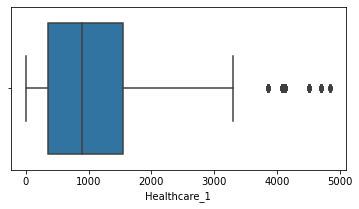

In [35]:
plt.figure(figsize=(6, 3))

sns.boxplot(x=df_train['Healthcare_1'], whis=1.5)

plt.xlabel('Healthcare_1')
plt.show()

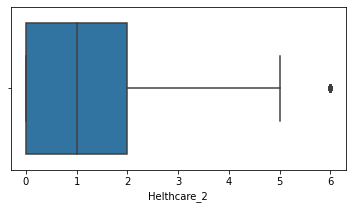

In [36]:
plt.figure(figsize=(6, 3))

sns.boxplot(x=df_train['Helthcare_2'], whis=1.5)

plt.xlabel('Helthcare_2')
plt.show()

Shops

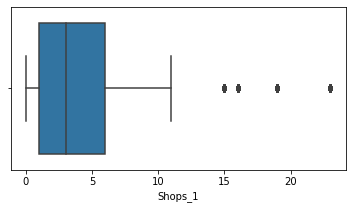

In [37]:
plt.figure(figsize=(6, 3))

sns.boxplot(x=df_train['Shops_1'], whis=1.5)

plt.xlabel('Shops_1')
plt.show()

### Предобработка

In [38]:
class CourseProjectDataPreprocessing:
    
    def __init__(self):
        self.target_name = 'Price'
        self.medians = []
    
    def fit(self, inner_df):
        # Расчет медиан
        self.medians = inner_df[['Square','LifeSquare','Social_2', 'Social_3','Healthcare_1','Helthcare_2', 'KitchenSquare', 'HouseYear', 'Rooms', 'Shops_1']].median()
    
    
    def transform(self, inner_df, is_test=False):
        
        #Заменяем пропуски на медианы
        inner_df[['LifeSquare','Healthcare_1']] = inner_df[['LifeSquare','Healthcare_1']].fillna(self.medians[['LifeSquare','Healthcare_1']])
    
        #Конвертируем HouseFloor, Rooms, Healthcare_1 в int
        inner_df['HouseFloor'] = inner_df['HouseFloor'].astype("int8")
        inner_df['Rooms'] = inner_df['Rooms'].astype(int)
        inner_df['Healthcare_1'] = inner_df['Healthcare_1'].astype(int)
        
        #Заменяем слишком большое количество комнат на посчитанное количество комнат = жилая площадь // 12
        many_rooms_df = inner_df.loc[inner_df['Rooms'] > 6]
        measured_rooms =  many_rooms_df['LifeSquare'] // 12
        inner_df.loc[inner_df['Rooms'] > 6, 'Rooms'] = measured_rooms
        
        #Заменяем нулевые значения HouseFloor на Floor
        inner_df.loc[(inner_df['HouseFloor'] == 0) | (inner_df['HouseFloor'] < inner_df['Floor']), 'HouseFloor'] = inner_df['Floor']
        
        #Заменяем нулевые значения и крупные KitchenSquare на медиану
        self.replace_with_median(inner_df, (inner_df['KitchenSquare'] <= 0) | (inner_df['KitchenSquare'] > 100), 'KitchenSquare')
        
        #Заменяем крайне малые и крайне большие значения LifeSquare медианой
        self.replace_with_median(inner_df, (inner_df['LifeSquare'] < 1) | (inner_df['LifeSquare'] > 1000), 'LifeSquare')
        
        #Заменяем крайне малые и крайне большие значения Square медианой
        self.replace_with_median(inner_df, (inner_df['Square'] < 6) | (inner_df['Square'] > 300), 'Square')
        
        #Устранение выбросов HouseYear
        self.replace_with_median(inner_df, (inner_df['HouseYear'] <= 0) | (inner_df['HouseYear'] > 2021), 'HouseYear')
        
        #Замена нулевых значений Rooms на медиану.
        self.replace_with_median(inner_df, inner_df['Rooms'] <= 0, 'Rooms')
        
        #Замена выбросов в Social
        self.replace_with_median(inner_df, inner_df['Social_2'] > 15000, 'Social_2')
        self.replace_with_median(inner_df, inner_df['Social_3'] > 20, 'Social_3')
        
        #Замена выбросов в Healthcare
        self.replace_with_median(inner_df, inner_df['Healthcare_1'] > 3500, 'Healthcare_1')
        self.replace_with_median(inner_df, inner_df['Helthcare_2'] > 5, 'Helthcare_2')
        
        #Замена выбросов в Shops
        self.replace_with_median(inner_df, inner_df['Shops_1'] > 15, 'Shops_1')
        
        
        return inner_df
        
                
    def replace_with_median(self, df:pd.DataFrame, condition:pd.Series, feature:str):
        df.loc[condition, feature] = self.medians[feature]


### Стандартизация

In [39]:
class CourseProjectScaler:
    
    def __init__(self):
        self.target_name = 'Price'
        self.feature_names = []
        self.feature_names_for_stand = []
        self.scaler = StandardScaler()
        
    
    def fit(self, inner_df):
        self.feature_names = get_feature_names(inner_df, self.target_name)
        self.feature_names_for_stand = inner_df[self.feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
        self.scaler.fit(inner_df[self.feature_names_for_stand])
           
    
    
    def transform(self, inner_df):
        #Стандартизация
        if len(self.feature_names_for_stand) > 0:
            stand_features = self.scaler.transform(inner_df[self.feature_names_for_stand])
            inner_df[self.feature_names_for_stand] = pd.DataFrame(stand_features, columns=self.feature_names_for_stand)
        return inner_df

### Обработка признаков

In [40]:
class CourseProjectFeatureProcessor:
    
    def __init__(self):
        self.target_name = 'Price'
        self.district_size = None
    
    
    def fit(self, inner_df):
        # создание соответствий между DistrictId и DistrictSize
        self.district_size = inner_df['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
    
    def transform(self, inner_df, is_test=False):
        #Удаляем ненужный признак Id
        inner_df = inner_df.drop(columns="Id")
        inner_df = inner_df.drop(columns="Ecology_2")
        inner_df = inner_df.drop(columns="Ecology_3")
        inner_df = inner_df.drop(columns="Shops_2")
        
#         #Перевод категориальных признаков
#         #Ecology_2/3
#         inner_df = self.replace_with_dummies(inner_df, 'Ecology_2', 'Ecology_2')
#         inner_df = self.replace_with_dummies(inner_df, 'Ecology_3', 'Ecology_3')
#         #Shops_2
#         inner_df = self.replace_with_dummies(inner_df, 'Shops_2', 'Shops_2')
        
        #Добавление категории дома по возрасту
        inner_df = self.year_to_cat(inner_df)
        
        #Добавление категории дома по этажности
        inner_df = self.house_floor_to_cat(inner_df)
        
        #Добавление признака First floor
        floor_df = inner_df['Floor'] == 1
        floor_df = floor_df.rename('is_first_floor')
        inner_df = pd.concat([inner_df, floor_df], axis=1)
        
#         #Добавление признака has_a_class_shops
#         shops_df = (inner_df['Shops_1'] > 0) & (inner_df['Shops_2_A'] > 0)
#         shops_df = shops_df.rename('has_a_class_shops')
#         inner_df = pd.concat([inner_df, shops_df], axis=1)
              
        #Добавление признака has_best_social_services
        social_df = ((inner_df['Social_1'] > 0) & (inner_df['Social_2'] > 0) & (inner_df['Social_3'] > 0))
        social_df = social_df.rename('has_best_social_services')
        inner_df = pd.concat([inner_df, social_df], axis=1)

        #Добавление признака has_health_care
        health_df = (inner_df['Healthcare_1'] > 0) & (inner_df['Helthcare_2'] > 0)
        health_df = health_df.rename('has_health_care')
        inner_df = pd.concat([inner_df, health_df], axis=1)
        
        #Удаление Ecology2/3
#         inner_df = inner_df.drop(columns="Ecology_2_A")
#         inner_df = inner_df.drop(columns="Ecology_2_B")
#         inner_df = inner_df.drop(columns="Ecology_3_A")
#         inner_df = inner_df.drop(columns="Ecology_3_B")
                
        #Добавление DistrictSize
        inner_df = inner_df.merge(self.district_size, on='DistrictId', how='left')
        
        #Замена пропусков DistrictSize
        ser = inner_df.loc[inner_df['DistrictSize'].isna(), 'DistrictId']
        ser_df = ser.reset_index()
        vc_df = ser.value_counts().reset_index().rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})
        filled_df = ser_df.merge(vc_df, on='DistrictId', how='left')
        filled_df = filled_df.set_index('index')
        inner_df.loc[inner_df['DistrictSize'].isna(), ['DistrictId','DistrictSize']] = inner_df.loc[inner_df['DistrictSize'].isna(), ['DistrictId','DistrictSize']].fillna(filled_df)

        return inner_df
        
    def replace_with_dummies(self, df, feature, prefix):
        df = pd.concat([df, pd.get_dummies(df[feature], prefix)], axis=1)
        df = df.drop(columns=feature)
        return df
    
    def year_to_cat(self, X):

        X['year_cat'] = 0

        X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

        return X
    
    
    def house_floor_to_cat(self, X):

        X['house_height_cat'] = 0

        X.loc[X['HouseFloor'] <= 5, 'house_height_cat'] = 1
        X.loc[(X['HouseFloor'] > 5) & (X['HouseFloor'] <= 10), 'house_height_cat'] = 2
        X.loc[(X['HouseFloor'] > 10) & (X['HouseFloor'] <= 15), 'house_height_cat'] = 3
        X.loc[(X['HouseFloor'] > 15) & (X['HouseFloor'] <= 20), 'house_height_cat'] = 4
        X.loc[(X['HouseFloor'] > 20) & (X['HouseFloor'] <= 25), 'house_height_cat'] = 5
        X.loc[(X['HouseFloor'] > 25), 'house_height_cat'] = 6

        return X 
    
    
    
    

### Применяем классы для обработки тренировочных данных

In [41]:
data_preprocessing = CourseProjectDataPreprocessing()
data_scaler = CourseProjectScaler()
feature_processor = CourseProjectFeatureProcessor()
    
data_preprocessing.fit(df_train)
df_train = data_preprocessing.transform(df_train)
data_scaler.fit(df_train)
df_train = data_scaler.transform(df_train)
feature_processor.fit(df_train)
df_train = feature_processor.transform(df_train)

### Обработка тестовых данных

In [42]:
df_test_transformed = data_preprocessing.transform(df_test)
df_test_transformed = feature_processor.transform(df_test_transformed)
df_test_transformed = data_scaler.transform(df_test_transformed)
df_train.shape, df_test_transformed.shape

((10000, 22), (5000, 21))

### Анализ предобработанных данных и поиск зависимостей

Привожу несколько графиков, но сам я явных сильных зависимостей тут не вижу

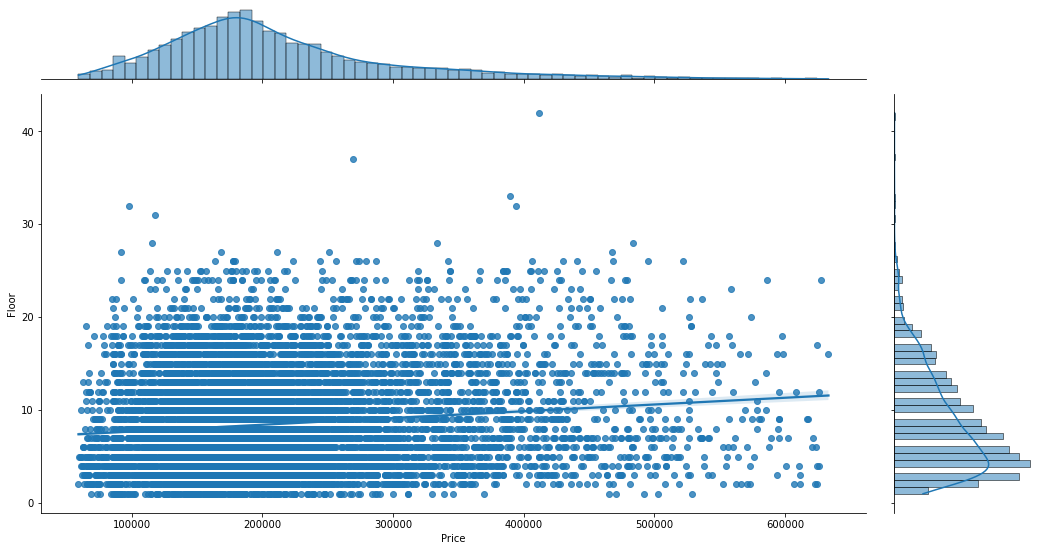

CPU times: user 3.92 s, sys: 104 ms, total: 4.02 s
Wall time: 842 ms


In [43]:
%%time
grid = sns.jointplot(x=df_train['Price'], y=df_train['Floor'], kind='reg')
grid.fig.set_figwidth(16)
grid.fig.set_figheight(8)

plt.show()

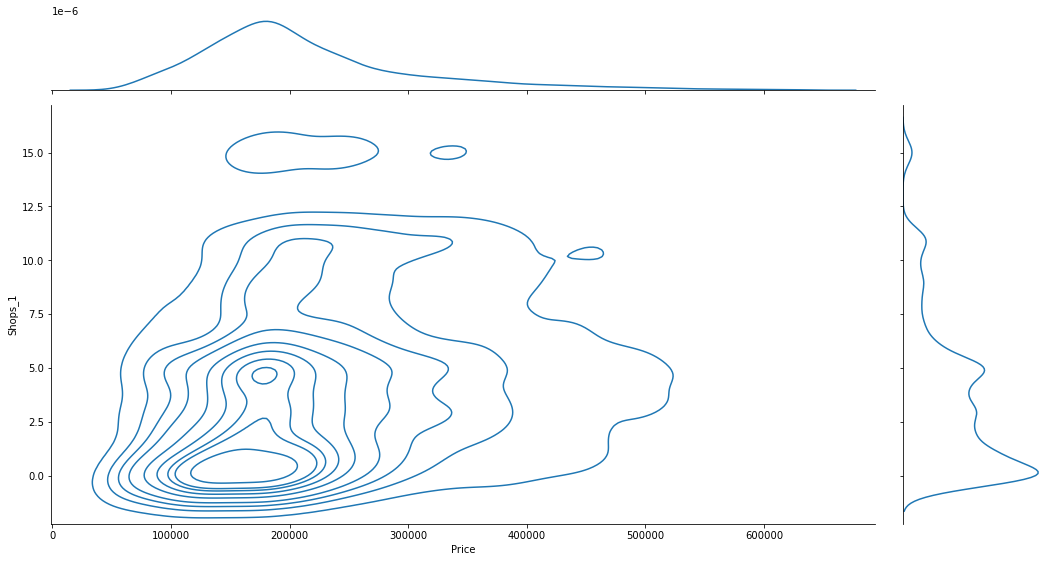

CPU times: user 5.7 s, sys: 44.8 ms, total: 5.75 s
Wall time: 3.91 s


In [44]:
%%time
grid = sns.jointplot(x=df_train['Price'], y=df_train['Shops_1'], kind='kde')
grid.fig.set_figwidth(16)
grid.fig.set_figheight(8)

plt.show()

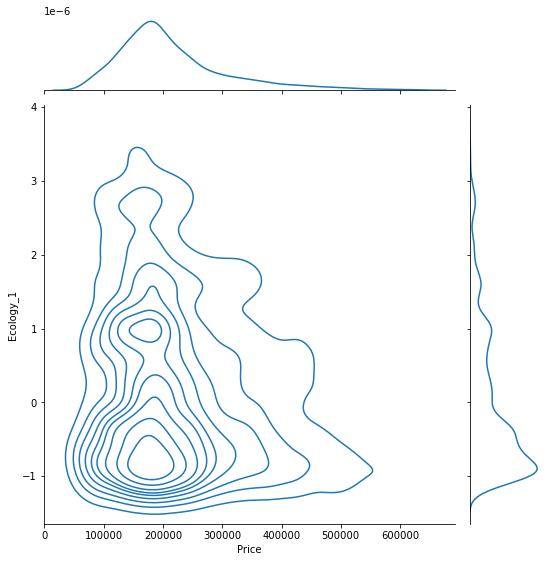

CPU times: user 5.67 s, sys: 67 ms, total: 5.74 s
Wall time: 3.85 s


In [45]:
%%time
grid = sns.jointplot(x=df_train['Price'], y=df_train['Ecology_1'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

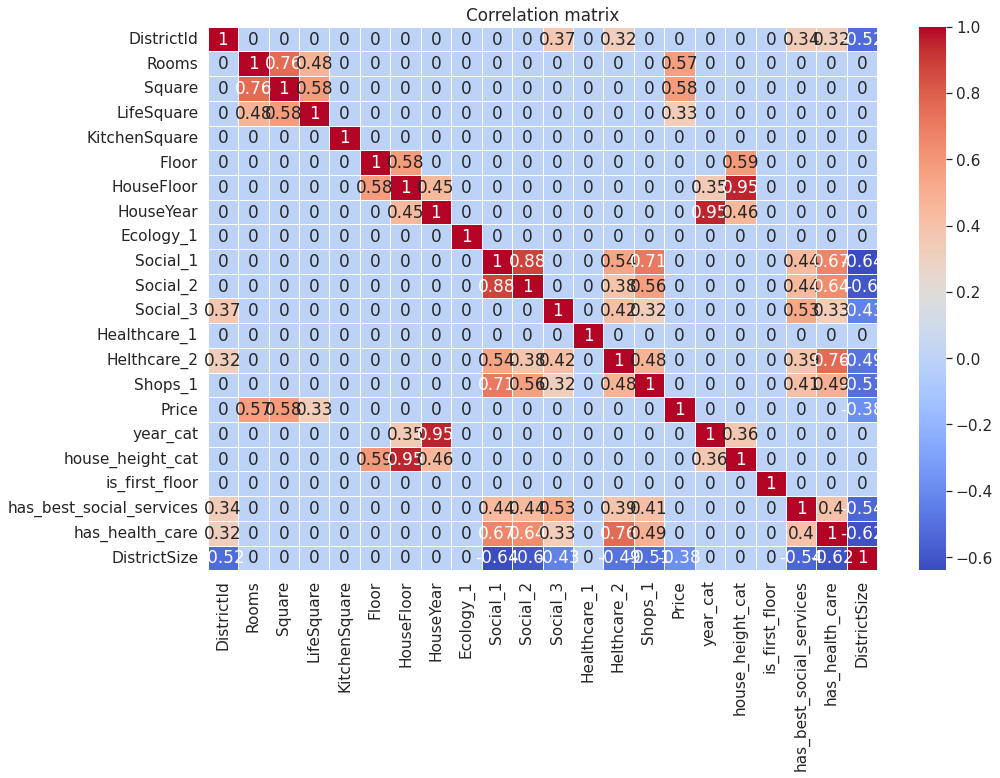

In [46]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Обучение модели

In [47]:
class CourseProjectModelLearningProcessor:
    
    def __init__(self):
        self.target_name = 'Price'
        self.trn_dataset = None
        self.test_dataset = None
        #Original = Before transformations
        self.original_test_dataset = None
        #Для заключительного обучения
        self.trn_X_full = None
        self.trn_y_full = None
        #Для промежуточного обучения и анализа
        self.trn_X_split_train = None
        self.trn_y_split_train = None
        self.trn_X_split_test = None
        self.trn_y_split_test = None
        
        self.split_y_train_preds = None
        self.full_y_train_preds = None
        self.test_preds = None
        
        self.cross_val_full_result = None
        self.cross_val_split_result = None
        
    def fit(self, trn_dataset, test_dataset, original_test_dataset):
        #заполнение и разделение датасетов
        self.trn_dataset = trn_dataset
        self.test_dataset = test_dataset
        self.original_test_dataset = original_test_dataset
        
        feature_names = get_feature_names(trn_dataset, self.target_name)
        self.trn_X_full = trn_dataset[feature_names]
        self.trn_y_full = trn_dataset[self.target_name]

        self.trn_X_split_train, self.trn_X_split_test, self.trn_y_split_train, self.trn_y_split_test = \
        train_test_split(self.trn_X_full, self.trn_y_full, test_size=0.33, shuffle=True, random_state=42)
    
    def fit_predict_split(self, inner_model):
        self.fit_split(inner_model)
        self.predict_split(inner_model)
        
    def fit_split(self, inner_model):
        inner_model.fit(self.trn_X_split_train, self.trn_y_split_train)
        
    def predict_split(self, inner_model):
        inner_model.predict(self.trn_X_split_train)
        self.split_y_train_preds = inner_model.predict(self.trn_X_split_train)
        self.split_y_test_preds = inner_model.predict(self.trn_X_split_test)
        
    def evaluate_split(self, inner_model, with_cross_val=False):
        evaluate_preds(np.squeeze(self.trn_y_split_train.values), self.split_y_train_preds)
        evaluate_preds(np.squeeze(self.trn_y_split_test.values), self.split_y_test_preds)
        if with_cross_val:
            self.cross_val_split_result = self.cross_val_split(inner_model)
            print(self.cross_val_split)
        
        
    def fit_predict_full(self, inner_model):
        self.fit_full(inner_model)
        self.predict_full(inner_model)
        
    def fit_full(self, inner_model):
        inner_model.fit(self.trn_X_full, self.trn_y_full)
        
    def predict_full(self, inner_model):
        inner_model.predict(self.trn_X_full)
        self.full_y_train_preds = inner_model.predict(self.trn_X_full)
        
    def evaluate_full(self, inner_model, with_cross_val=False):
        evaluate_preds(np.squeeze(self.trn_y_full.values), self.full_y_train_preds)
        if with_cross_val:
            self.cross_val_full_result = self.cross_val_full(inner_model)
            print(self_cross_val_full)
        
    def predict_test(self, inner_model):
        self.test_preds = inner_model.predict(self.test_dataset)
        
    def save_test(self, prefix):
        result_df = pd.DataFrame(self.test_preds, columns=['Price'])
        result_df = pd.concat([self.original_test_dataset['Id'], result_df], axis=1)
        date = datetime.datetime.now()
        timestamp = f"{date.year}-{date.month}-{date.day}-{date.hour}-{date.minute}-{date.second}"
        result_df.to_csv(f"{prefix}_predictions-{timestamp}.csv", index=False)
        
    def cross_val_split(self, inner_model):
        cv_score = cross_val_score(inner_model, self.trn_X_split_train, self.trn_y_split_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21), n_jobs=-1)
        return cv_score
        
    def cross_val_full(self, inner_model):
        cv_score = cross_val_score(inner_model, self.trn_X_full, self.trn_y_full, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
        return cv_score

### Генерация модели

In [48]:
class CourseProjectModelFactory:
    
    def __init__(self):
        pass
    
    def get_stack_model(self, models=None):
        if models == None:
            inner_gb_model = self.get_gb_model()
            inner_xgb_model = self.get_xgb_model()
            inner_lgb_model = self.get_lgb_model()
            
            models = [('gb', inner_gb_model), ('xgb', inner_xgb_model), ('lbg', inner_lgb_model)]
            
        return StackingRegressor(models)
    
    def get_gb_model(self):
        
#         gb_model = GradientBoostingRegressor(  loss="lad",
#                                         learning_rate=0.01,
#                                         max_depth=10,
#                                         min_samples_leaf=10,
#                                         random_state=42,
#                                         n_estimators=1400
#                                     )
        inner_gb_model = GradientBoostingRegressor(  loss="lad",
                                        learning_rate=0.05,
                                        max_depth=6,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=1000
                                    )
        return inner_gb_model

    def get_xgb_model(self):
#         xgb_model = XGBRegressor(random_state=21,
#                       tree_method='hist',
#                       subsample=1.0,
#                       n_estimators=600,
#                       max_depth=3,
#                       importance_type='total_cover',
#                       colsample_bytree=1.0,
#                       booster='dart')
        inner_xgb_model = XGBRegressor(random_state=21,
                      tree_method='hist',
                      subsample=1.0,
                      n_estimators=1000,
                      learning_rate=0.01,
                      max_depth=6,
                      importance_type='total_cover',
                      colsample_bytree=1.0,
                      booster='dart',
                      n_jobs=-1)
        
        return inner_xgb_model
    
    
    def get_lgb_model(self):
        # lgb_model = LGBMRegressor(random_state=21, 
#              num_leaves=10,
#              n_estimators=1000,
#              max_depth=5,
#              max_bin=30,
#              learning_rate= 0.03)
        inner_lgb_model = LGBMRegressor(random_state=21, 
             num_leaves=10,
             n_estimators=1000,
             max_depth=5,
             max_bin=300,
             learning_rate= 0.03,
            n_jobs=-1)
    
        return inner_lgb_model
        
# parameters = {'learning_rate': [0.04, 0.06, 0.08, 0.1, 0.2, 0.5],
#                   'min_samples_leaf':[i for i in range(1, 11)]
#                  }
# gs_gb = GridSearchCV(gb_model, parameters, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs_gb.fit(train, target)
# gs_gb.best_params_   

### Применение

Создаем модель

In [49]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,year_cat,house_height_cat,DistrictSize
count,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888900,1.271963e-08,1.223326e-07,-1.216371e-07,8.526700,13.435700,1984.863800,7.546693e-09,24.687000,5109.312600,2.707800,954.873400,1.270000,3.555000,214138.937500,3.811700,3.071800,242.306600
std,43.587592,0.812295,1.000049e+00,1.000056e+00,1.000054e+00,5.241148,6.094012,18.409979,1.000047e+00,17.532614,3560.474465,3.362135,571.993815,1.418627,3.442493,92872.273438,1.168495,1.243302,268.992652
min,0.000000,1.000000,-2.226342e+00,-1.910883e+00,-1.159521e+00,1.000000,1.000000,1910.000000,-9.986406e-01,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,1.000000,1.000000,1.000000
25%,20.000000,1.000000,-7.569925e-01,-5.531446e-01,-4.983733e-01,4.000000,9.000000,1974.000000,-8.503701e-01,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.628906,3.000000,2.000000,55.000000
50%,36.000000,2.000000,-1.946895e-01,-1.525438e-01,-5.760803e-02,7.000000,14.000000,1977.000000,-3.649310e-01,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438,3.000000,3.000000,104.000000
75%,75.000000,2.000000,5.070235e-01,3.263298e-01,6.035399e-01,12.000000,17.000000,2001.000000,6.463113e-01,36.000000,7065.000000,4.000000,900.000000,2.000000,5.000000,249135.460938,5.000000,4.000000,511.000000
max,209.000000,6.000000,1.151058e+01,3.339362e+01,1.977683e+01,42.000000,117.000000,2020.000000,3.386085e+00,74.000000,14892.000000,20.000000,3300.000000,5.000000,15.000000,633233.437500,6.000000,6.000000,851.000000


In [50]:
model_factory = CourseProjectModelFactory()

stack_model = model_factory.get_stack_model()

Обучаем на разделенных тренировочных данных(split)

In [51]:
mp = CourseProjectModelLearningProcessor()
mp.fit(df_train, df_test_transformed, df_test)

In [52]:
%%time
# mp.fit_split(stack_model)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


Предсказываем(split)

In [53]:
# mp.predict_split(stack_model)

Оцениваем(split)

In [54]:
%%time
# mp.evaluate_split(stack_model)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.34 µs


Смотрим кросс-валидацию(split), если была посчитана (evaluate_split(model, True))

In [55]:
mp.cross_val_split_result

Обучаем на полных тренировочных данных(full_train)

In [56]:
%%time
mp.fit_full(stack_model)

CPU times: user 45min 51s, sys: 10.7 s, total: 46min 1s
Wall time: 6min 14s


Предсказываем(full_train)

In [57]:
mp.predict_full(stack_model)

Оцениваем(full_train)

R2:	0.849
RMSE:	36080.315
MSE:	1301789115.002


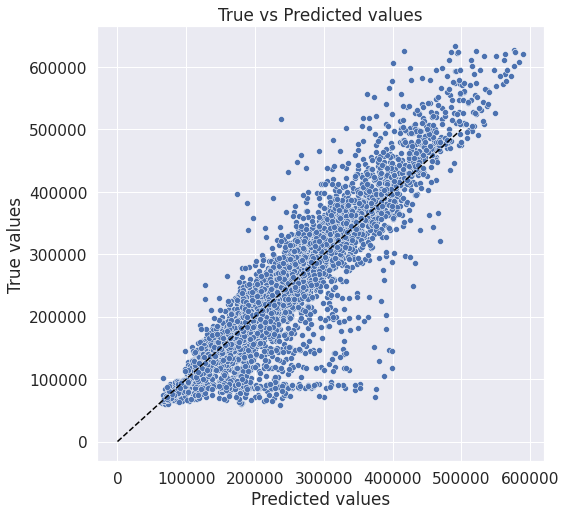

CPU times: user 2.14 s, sys: 59.9 ms, total: 2.2 s
Wall time: 257 ms


In [58]:
%%time
mp.evaluate_full(stack_model)

Смотрим кросс-валидацию(full), если была посчитана (evaluate_full(model, True))

In [59]:
#mp.cross_val_full_result

Предсказываем на целевых данных(test) и сохраняем предсказания в файл

In [60]:
mp.predict_test(stack_model)
mp.save_test('stack_model')